In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [3]:
class ProteinDataset(Dataset):
    def __init__(self, num_samples, seq_length):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.sequences = self.generate_random_sequences(num_samples, seq_length)
        self.torsions = np.random.rand(num_samples, seq_length)  

    def generate_random_sequences(self, num_samples, seq_length):
        amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
        return [''.join(np.random.choice(amino_acids, seq_length)) for _ in range(num_samples)]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        torsion_angles = self.torsions[idx]

        seq_tensor = torch.tensor([ord(c) for c in seq], dtype=torch.float32)  
        torsion_tensor = torch.tensor(torsion_angles, dtype=torch.float32)  
        
        return seq_tensor, torsion_tensor

In [4]:
class ProteinPredictor(nn.Module):
    def __init__(self, input_dim):
        super(ProteinPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, input_dim)  
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [5]:
def plot_loss(history):
    plt.plot(history)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


def plot_predictions(predictions, true_values):
    plt.figure(figsize=(10, 5))
    plt.plot(true_values.flatten(), label='True Torsions')
    plt.plot(predictions.flatten(), label='Predicted Torsions')
    plt.title('Predictions vs True Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Torsion Angles')
    plt.legend()
    plt.show()

In [6]:
train_dataset = ProteinDataset(num_samples=1000, seq_length=50)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProteinPredictor(input_dim=50).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


loss_history = []

for epoch in range(10):
    model.train()
    epoch_loss = 0
    for seq, torsion in train_loader:
        seq, torsion = seq.to(device), torsion.to(device)
        optimizer.zero_grad()
        outputs = model(seq)
        loss = criterion(outputs, torsion)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

Epoch 1, Loss: 3.0674386117607355
Epoch 2, Loss: 0.26404606318101287
Epoch 3, Loss: 0.17186606163159013
Epoch 4, Loss: 0.11790866637602448
Epoch 5, Loss: 0.09757996676489711
Epoch 6, Loss: 0.0894406212028116
Epoch 7, Loss: 0.087055693147704
Epoch 8, Loss: 0.08639329276047647
Epoch 9, Loss: 0.08589235879480839
Epoch 10, Loss: 0.08568394952453673


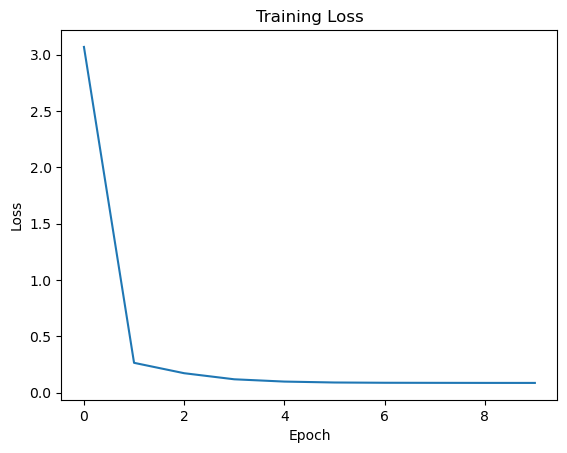

In [7]:
plot_loss(loss_history)

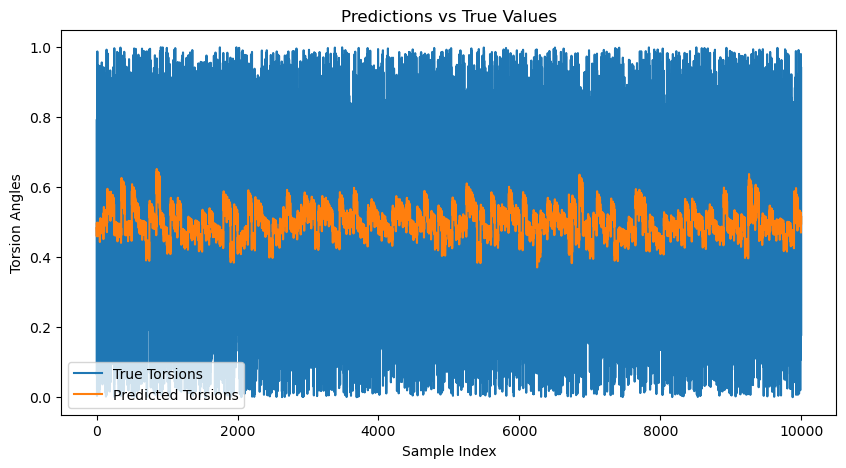

In [8]:
model.eval()
test_dataset = ProteinDataset(num_samples=200, seq_length=50)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []
true_values = []

with torch.no_grad():
    for seq, torsion in test_loader:
        seq, torsion = seq.to(device), torsion.to(device)
        output = model(seq)
        predictions.append(output.cpu().numpy())
        true_values.append(torsion.cpu().numpy())

predictions = np.array(predictions)
true_values = np.array(true_values)

# Plot the predictions vs true values
plot_predictions(predictions, true_values)